In [3]:
import xarray as xr
from xhistogram.xarray import histogram
import richdem as rd
import rioxarray as rxr
import xrspatial as xrs
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

import pysolar
from datetime import datetime

from aster_utils import mapZonalStats

from asp_binder_utils import get_dem

import warnings
warnings.filterwarnings('ignore')

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/osgeo/gdal.py:107: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


In [4]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

---

In [5]:
ds = xr.open_dataset('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG_v4_orthorectified.nc')

---

In [6]:
modscag_filepaths = glob.glob('/storage/MODIS/Tuolumne_MOD09GA/*.tif')

In [7]:
modscag_da_list = []
for modscag_filepath in modscag_filepaths:
    _da = xr.open_rasterio(modscag_filepath)
    _da_masked = _da.where(_da <= 100)
    _da_masked = _da_masked.squeeze().drop('band')
    this_time = pd.Timestamp(datetime.strptime(_da_masked.attrs['TIFFTAG_DATETIME'],'%Y:%m:%d %H:%M:%S'))#np.datetime64(datetime.strptime(_da_masked.attrs['TIFFTAG_DATETIME'],'%Y:%m:%d %H:%M:%S'))
    _da_masked = _da_masked.assign_coords({'time':this_time})
    modscag_da_list.append(_da_masked.rio.reproject_match(ds))
    
# manually picking the ones I need to match my GOES/ASTER/MODIS dataset (including duplicates where we had 2 ASTER in one day)
idx = [2,3,4,4,5,10,11,12,20,21,21,22,23,24,26,26,29,29,34,34,36,36,37,38,39,40,41]
new_modscag_da_list = [modscag_da_list[i] for i in idx]

In [8]:
modscag_da = xr.concat(new_modscag_da_list, dim='time')
modscag_da['time'] = ds.time.values # overwrite time values with ASTER times
ds['modscag'] = modscag_da # add to main dataset

---

Function for creating a fractional snow covered area from MODSCAG via a binary snow

In [9]:
def fsca_mapZonalStats(zones, zonalstats, stat_name):
    ''' Function for mapping the zonal statistics back to the original grid to get a 2D map of the chosen statistic'''
    # create an empty array for this summary stat
    zonal_stat = np.zeros_like(zones.values, dtype=np.float64)

    # for each zone
    for zone_n in zonalstats.index.values:
        # get the summary stat for that zone, 
        # and assign it to the correct locations in the zonal_stat array
        #try:
        zonal_stat[zones.values==zone_n] = zonalstats['{}'.format(stat_name)].loc[zone_n]
        #except: #MaskError: Cannot convert masked element to a Python int.
        #    zonal_stat[zones.values==zone_n] = -9999

    # convert this to an xarray data array with the proper name
    zonal_stat_da = xr.DataArray(zonal_stat, 
                                 dims=["y", "x"],
                                 coords=dict(
                                             x=(["x"], zones.x),
                                             y=(["y"], zones.y),
                                             ),
                                 name='zonal_{}'.format(stat_name))
    # remove nodata values
    zonal_stat_da = zonal_stat_da.where(zonal_stat_da!=-9999, np.nan)

    return zonal_stat_da     

In [18]:
def modscag_to_binary_snow(modscag, threshold):
    
    intermediate_map = modscag.where((np.isnan(modscag))|(modscag>threshold),0)
    
    binary_snow = intermediate_map.where((np.isnan(intermediate_map))|(intermediate_map<threshold), 1)
    
    return binary_snow

ds['binary_snow_gt50'] = modscag_to_binary_snow(ds.modscag, 50)

In [19]:
da_fsca_mean_stack = []
for i in range(0,len(ds.time)):
    fsca_mean = ds.isel(time=i).groupby('ast_goes_goes_zones').mean().binary_snow_gt50.to_dataframe()
    da_fsca_mean = fsca_mapZonalStats(ds.isel(time=i).ast_goes_goes_zones, fsca_mean, 'binary_snow_gt50')
    da_fsca_mean_stack.append(da_fsca_mean)
    
ds_fsca_mean = xr.concat(da_fsca_mean_stack, 'time' )
ds['fsca'] = ds_fsca_mean.where(~np.isnan(ds.ast_goes_goes_zones))

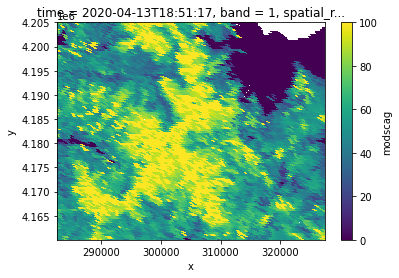

In [20]:
ds.isel(time=26).modscag.plot()

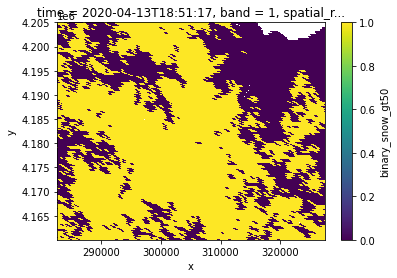

In [21]:
ds.isel(time=26).binary_snow_gt50.plot()

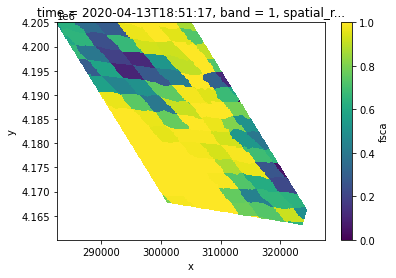

In [22]:
ds.isel(time=26).fsca.plot()

---
### save out to file

In [23]:
ds.to_netcdf('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG-FSCA_v5_orthorectified.nc')